# Лабораторна робота №1
## Класифікація зображень за допомогою PyTorch

**Мета роботи: Навчитись тренувати базову нейронну мережу для класифікації зображень.**

**Вимоги:**

1.   Встановлені Python та бібліотеки PyTorch, torchvision, matplotlib.
2.   Завантажений набір даних CIFAR-10.

## Завдання до лабораторної роботи (частина І): Робота з даними (CIFAR-10)

1.   Імпортуйте необхідні бібліотеки:
```
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid
```
2.   Завантаження даних. Напишіть функцію, яка завантажує набір даних CIFAR-10.
3.   Перевірка наявності даних. Напишіть код, який перевіряє, чи дані завантажені та розпаковані успішно. Виведіть повідомлення про статус завантаження.
4.   Підготовка даних. Напишіть код, щоб імплементувати трансформації для зображень:
*    перетворення в тензори;
*    денормалізація (при необхідності).  

Використайте `torchvision.transforms` для підготовки даних.
5.   Створення DataLoader. Створіть DataLoader для навчального та тестового наборів даних, щоб спростити процес завантаження даних за батчами.
6.   Візуалізація прикладів:
*   напишіть функцію для візуалізації деяких зображень з набору даних;
*   відобразіть кілька зображень з їхніми реальними мітками.
7.   Ваші висновки до частини І.

In [ ]:
# new python virtual environment, in the terminal in the core folder:

# python -m venv myvenv
# myvenv\Scripts\activate

# pip install -r requirements.txt
# pip install numpy pandas

# deactivate

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid
from collections import Counter
import os
import torch.optim as optim
from torchsummary import summary
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import random
from PIL import Image

In [2]:
train_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        transforms.RandomHorizontalFlip(0.2),
        transforms.RandomRotation(10),
        transforms.ColorJitter(0.2, 0.2)
    ])

test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [ ]:
# denormalization to show pictures in real colors

def imshow(img):
    img = img * 0.5 + 0.5
    nping = img.numpy() if isinstance(img, torch.Tensor) else img
    plt.imshow(np.transpose(nping, (1, 2, 0)))
plt.show()

In [89]:
def load_cifar_dataset(data_dir="./data", batch_size=32, train_transform=test_transform, test_transform=test_transform):
    train_dataset = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True, transform=train_transform)
    test_dataset = torchvision.datasets.CIFAR10(root=data_dir, train=False, download=True, transform=test_transform)
    
    train_size = int((1 - 0.1) * len(train_dataset))
    val_size = len(train_dataset) - train_size
    
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    
    return train_loader, val_loader, test_loader

In [90]:
train_data, val_data, test_data = load_cifar_dataset()
classes = test_data.dataset.classes

Files already downloaded and verified
Files already downloaded and verified


In [43]:
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [44]:
len(train_data.dataset)

45000

In [45]:
len(val_data.dataset)

5000

In [46]:
len(test_data.dataset)

10000

In [47]:
def verify_data_existence(data_dir="./data"):
    """Перевіряє, чи завантажені та розпаковані дані CIFAR-10."""
    data_path = os.path.join(data_dir, "cifar-10-batches-py")
    
    if os.path.exists(data_path):
        print("✅ Дані CIFAR-10 успішно завантажені та розпаковані.")
    else:
        print("❌ Дані CIFAR-10 відсутні. Переконайтеся, що вони завантажені правильно.")

verify_data_existence()

✅ Дані CIFAR-10 успішно завантажені та розпаковані.


Огляд тренувального датасету CIFAR-10
-----------------------------
🔹 Загальна кількість зображень: 50000
🔹 Розмірність зображень: (32, 32, 3)
🔹 Кількість класів: 10
🔹 Список класів:
   0: airplane (5000 зразків)
   1: automobile (5000 зразків)
   2: bird (5000 зразків)
   3: cat (5000 зразків)
   4: deer (5000 зразків)
   5: dog (5000 зразків)
   6: frog (5000 зразків)
   7: horse (5000 зразків)
   8: ship (5000 зразків)
   9: truck (5000 зразків)


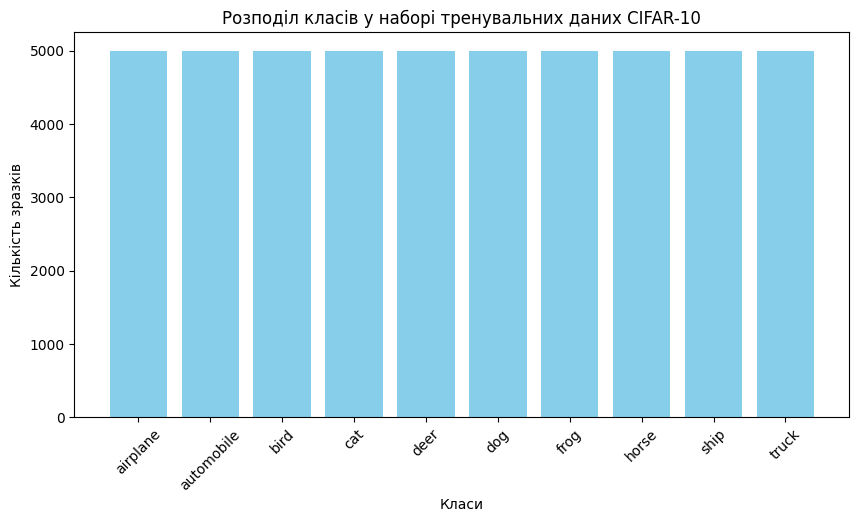

In [18]:
def dataset_statistics(dataset, classes):
    num_samples = len(dataset)
    image_shape = dataset.data.shape[1:]
    labels = [label for _, label in dataset]
    label_counts = Counter(labels)
    
    print("Огляд тренувального датасету CIFAR-10")
    print("-----------------------------")
    print(f"🔹 Загальна кількість зображень: {num_samples}")
    print(f"🔹 Розмірність зображень: {image_shape}")
    print(f"🔹 Кількість класів: {len(classes)}")
    print("🔹 Список класів:")
    for i, cls in enumerate(classes):
        print(f"   {i}: {cls} ({label_counts[i]} зразків)")
    
    # Візуалізація розподілу класів
    plt.figure(figsize=(10, 5))
    plt.bar(classes, [label_counts[i] for i in range(len(classes))], color='skyblue')
    plt.xlabel("Класи")
    plt.ylabel("Кількість зразків")
    plt.title("Розподіл класів у наборі тренувальних даних CIFAR-10")
    plt.xticks(rotation=45)
    plt.show()
    
dataset_statistics(train_data.dataset, classes)

### Візуалізація

In [48]:
def show_sample_images(dataset, classes, num_images=6):
    """Відображає випадкові зображення з їхніми мітками."""
    fig, axes = plt.subplots(1, num_images, figsize=(12, 4))
    
    for i in range(num_images):
        index = np.random.randint(len(dataset))
        image, label = dataset[index]
        
        # Перетворення тензора в numpy-масив та приведення до коректного діапазону [0,1]
        image = image.permute(1, 2, 0).numpy() * 0.5 + 0.5  # Денормалізація
        
        axes[i].imshow(image)
        axes[i].set_title(classes[label])
        axes[i].axis("off")
    
    plt.show()

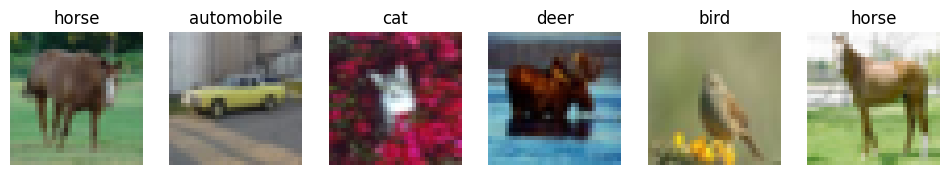

In [91]:
show_sample_images(train_data.dataset, classes)

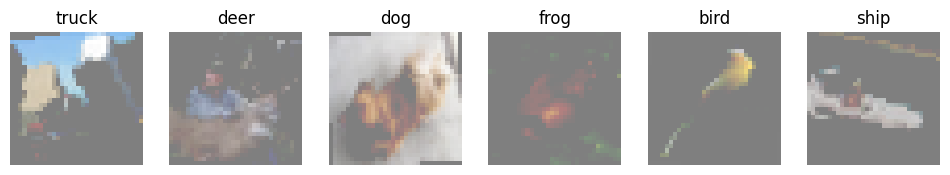

In [51]:
show_sample_images(val_data.dataset, classes)

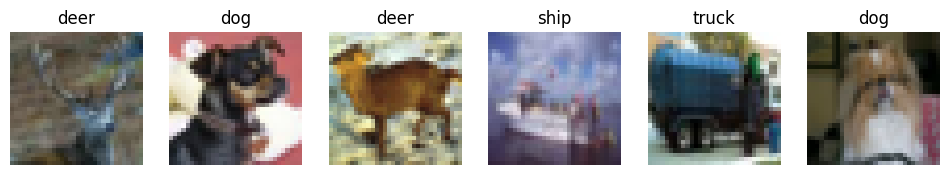

In [50]:
show_sample_images(test_data.dataset, classes)

In [55]:
def show_batch(data_loader):
    for images, labels in data_loader:
        images = images * 0.5 + 0.5
        fig, ax = plt.subplots(figsize=(20, 8))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1,2,0))
        break

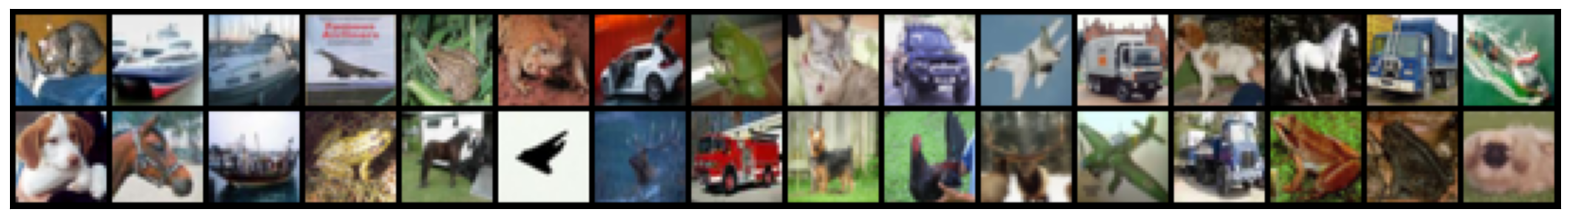

In [56]:
show_batch(test_data)

### Висновки

Був успішно завантажений та підготовлений для подальшого використання під час тренування моделі датасет. Це хороший збалансований тренувальний датасет для задачі класифікації зображень з лейблами з різнокольоровими (3 канали) зображеннями досить малого розширення (32х32), який містить 50000 тренувальних зразків на 10 класів. Чудовий для практики.

## Завдання до лабораторної роботи (частина ІІ):
0. Розділіть набір даних на навчальний і тестовий.
1. Визначення структури CNN.
    - Створіть клас для цільної нейронної мережі, яка буде містити мінімум два повнозв'язних шари.
2. Вибір функції втрати та оптимізатора:
    - визначте функцію втрат (наприклад, CrossEntropyLoss) та оптимізатор (наприклад, SGD або Adam).
3. Тренування моделі.
    - Реалізуйте цикл навчання, де:
        - модель тренується на навчальному наборі даних;
        - виводиться значення функції втрат та точність (на навчальній та валідаційній множинах) після кожної епохи.
4. Оцінка моделі:
    - визначте точність моделі на тестовому наборі даних;
    - виведіть детальні статистики (загальна точність та точність для кожного класу).
5. Візуалізація результатів:
    - візуалізуйте кілька випадкових передбачених зображень разом з їхніми реальними мітками та передбаченнями;
    - побудуйте графік точності та втрат для навчального набору даних на кожній епосі.

* A feed forward network is a network with no recurrent connections, that is, it is the opposite of a recurrent network (RNN). It is an important distinction because in a feed forward network the gradient is clearly defined and computable through backpropagation (i.e. chain rule), whereas in a recurrent network the gradient computation requires, potentially, an infinite number of operations, so you usually have to limit it to a fixed number of steps, and it is also more expensive in any case (see backpropagation through time).
* A fully-connected network, or maybe more appropriately a fully-connected layer in a network is one such that every input neuron is connected to every neuron in the next layer. This, for example, contrasts with convolutional layers, where each output neuron depends on a subset of the input neurons.

-> A classic multilayer perceptron is a feed forward network composed of fully connected layers. Most so-called "convolutional networks" are also feed forward and are composed of a number of convolutional and pooling layers, but also some fully connected layers.

A fully convolutional net tries to learn representations and make decisions based on local spatial input. Appending a fully connected layer enables the network to learn something using global information where the spatial arrangement of the input falls away and need not apply.

[Recurrent Neural Networks (RNNs)](https://www.geeksforgeeks.org/introduction-to-recurrent-neural-network/) work a bit different from regular neural networks. In neural network the information flows in one direction from input to output. However in RNN information is fed back into the system after each step. Think of it like reading a sentence, when you’re trying to predict the next word you don’t just look at the current word but also need to remember the words that came before to make accurate guess.

RNNs allow the network to “remember” past information by feeding the output from one step into next step. This helps the network understand the context of what has already happened and make better predictions based on that. For example when predicting the next word in a sentence the RNN uses the previous words to help decide what word is most likely to come next.

Feedforward Neural Networks (FNNs) process data in one direction from input to output without retaining information from previous inputs. This makes them suitable for tasks with independent inputs like image classification. However FNNs struggle with sequential data since they lack memory.

Recurrent Neural Networks (RNNs) solve this by incorporating loops that allow information from previous steps to be fed back into the network. This feedback enables RNNs to remember prior inputs making them ideal for tasks where context is important

**Usually same padding (output size=input size) + 1 stride + 3x3 kernel**

In [ ]:
class CNN1(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN1, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 16 * 16, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

model1 = CNN1()

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU6(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU6(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 128),
            nn.ReLU6(),
            nn.Linear(128, 64),
            nn.ReLU6(),
            nn.Linear(64, num_classes)
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

model2 = CNN()

In [ ]:
class CNN2(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN2, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU6(),
            # nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU6(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 16 * 16, 64),
            nn.ReLU6(),
            nn.Dropout(0.4),
            nn.Linear(64, num_classes)
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

model = CNN2()

In [116]:
criterion = nn.CrossEntropyLoss()  # Функція втрат
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Оптимізатор

print("Модель CNN створена, функція втрат та оптимізатор налаштовані.")

Модель CNN створена, функція втрат та оптимізатор налаштовані.


In [64]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU6()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU6()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=128, bias=True)
    (2): ReLU6()
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU6()
    (5): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [65]:
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
             ReLU6-2           [-1, 32, 32, 32]               0
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
             ReLU6-5           [-1, 64, 16, 16]               0
         MaxPool2d-6             [-1, 64, 8, 8]               0
           Flatten-7                 [-1, 4096]               0
            Linear-8                  [-1, 128]         524,416
             ReLU6-9                  [-1, 128]               0
           Linear-10                   [-1, 64]           8,256
            ReLU6-11                   [-1, 64]               0
           Linear-12                   [-1, 10]             650
Total params: 552,714
Trainable params: 552,714
Non-trainable params: 0
-------------------------------

In [94]:
epochs = 10

# якщо параметри не покращуються, тренування зупиняється (early stopping)
patience = 5
best_loss = 1e9

In [108]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

In [109]:
def train_model(model, train_loader, val_loader, criterion, optimizer, train_losses, val_losses, train_accuracies, val_accuracies, epochs=10, device="cuda"):
    model.to(device)
    
    for epoch in range(epochs):
        model.train()
        train_loss, correct_train, total_train = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            correct_train += predicted.eq(labels).sum().item()
            total_train += labels.size(0)

        train_acc = correct_train / total_train
        val_loss, val_acc, _, _ = evaluate_model(model, val_loader, criterion, device)

        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {train_loss/len(train_loader):.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")


def evaluate_model(model, data_loader, criterion, device="cuda"):
    model.eval()
    loss, correct, total = 0, 0, 0
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss += criterion(outputs, labels).item()
            
            _, predicted = outputs.max(1)
            all_preds.append(predicted.numpy())
            all_labels.append(labels.numpy())
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
    
    return loss / len(data_loader), correct / total, np.concatenate(all_labels), np.concatenate(all_preds)

In [120]:
epochs = 5
optimizer = optim.Adam(params=model.parameters() ,lr=0.0001)
train_model(model, train_data, val_data, criterion, optimizer, train_losses, val_losses, train_accuracies, val_accuracies, epochs, device)

Epoch [1/5] | Train Loss: 0.5121 | Train Acc: 0.8128 | Val Loss: 1.0027 | Val Acc: 0.6890
Epoch [2/5] | Train Loss: 0.4883 | Train Acc: 0.8202 | Val Loss: 1.0036 | Val Acc: 0.6880
Epoch [3/5] | Train Loss: 0.4648 | Train Acc: 0.8276 | Val Loss: 1.0165 | Val Acc: 0.6902
Epoch [4/5] | Train Loss: 0.4485 | Train Acc: 0.8340 | Val Loss: 1.0185 | Val Acc: 0.6904
Epoch [5/5] | Train Loss: 0.4370 | Train Acc: 0.8377 | Val Loss: 1.0337 | Val Acc: 0.6920


Data Augmentation	Apply transformations (rotate, flip, crop) to artificially enlarge the training set.

Regularization (L2, Dropout)	Add penalties to large weights (L2 regularization) or randomly drop neurons (dropout) during training.

Early Stopping	Monitor validation loss and stop training when it starts increasing.

Smaller Model	Use fewer layers/parameters if your dataset is small.

More Data	The best fix! More diverse data makes overfitting harder.

Batch Normalization	Helps stabilize training and can act as a regularizer.

Transfer Learning	Use a pretrained model instead of training from scratch, especially with small datasets.

Валідаційний датасет або маленький, або не репрезентативний, або недостатньо складний

Тут можна наступне:
- збільшити його, сіфар то дозволяє
- перевірити як там по розподілу даних (перевірено, він збалансований) 
- (?) такее накинути на валідацію грубшу аугментацію

In [121]:
def test_model_statistics(model, test_loader, classes, device="cuda"):
    model.to(device)
    test_loss, test_acc, all_labels, all_preds = evaluate_model(model, test_loader, criterion, device)
    print(f"\nЗагальна точність на тестовому наборі: {test_acc * 100:.2f}%")

    # Точність для кожного класу
    class_correct = torch.zeros(len(classes))
    class_total = torch.zeros(len(classes))

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)

            for i in range(len(labels)):
                label = labels[i].item()
                class_correct[label] += (predicted[i] == label).item()
                class_total[label] += 1

    print("\nТочність по класах:")
    for i, class_name in enumerate(classes):
        if class_total[i] > 0:
            print(f"   {class_name}: {100 * class_correct[i] / class_total[i]:.2f}%")
        else:
            print(f"   {class_name}: Немає даних")
    
    return test_loss, test_acc, all_labels, all_preds

In [122]:
test_loss, test_acc, all_labels, all_preds = test_model_statistics(model, test_data, classes, device)


Загальна точність на тестовому наборі: 68.99%

Точність по класах:
   airplane: 75.20%
   automobile: 78.80%
   bird: 54.50%
   cat: 52.40%
   deer: 63.60%
   dog: 59.90%
   frog: 75.00%
   horse: 74.30%
   ship: 75.90%
   truck: 80.30%


In [123]:
def plot_confusion_matrix(y_act, y_pred, classes):
  confusion_mat = confusion_matrix(y_act, y_pred)

  # Plot confusion matrix
  plt.figure(figsize=(10, 8))
  sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.title('Confusion Matrix')
  plt.show() 

In [124]:
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.69      0.75      0.72      1000
           1       0.83      0.79      0.81      1000
           2       0.55      0.55      0.55      1000
           3       0.49      0.52      0.51      1000
           4       0.64      0.64      0.64      1000
           5       0.61      0.60      0.61      1000
           6       0.78      0.75      0.76      1000
           7       0.73      0.74      0.73      1000
           8       0.83      0.76      0.79      1000
           9       0.77      0.80      0.79      1000

    accuracy                           0.69     10000
   macro avg       0.69      0.69      0.69     10000
weighted avg       0.69      0.69      0.69     10000



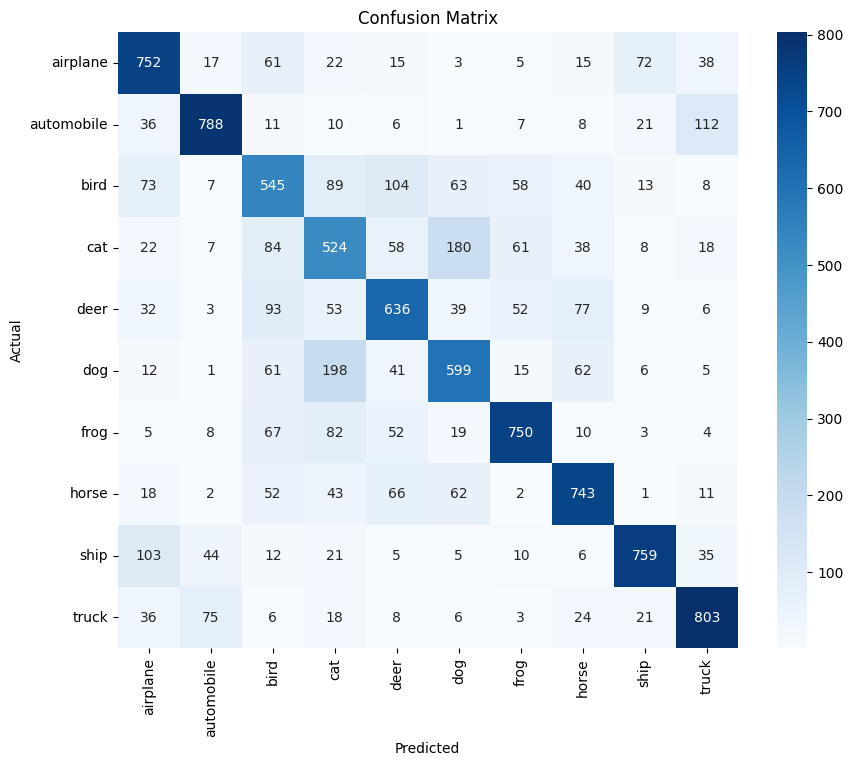

In [127]:
plot_confusion_matrix(all_labels, all_preds, classes)

### Візуалізація результатів

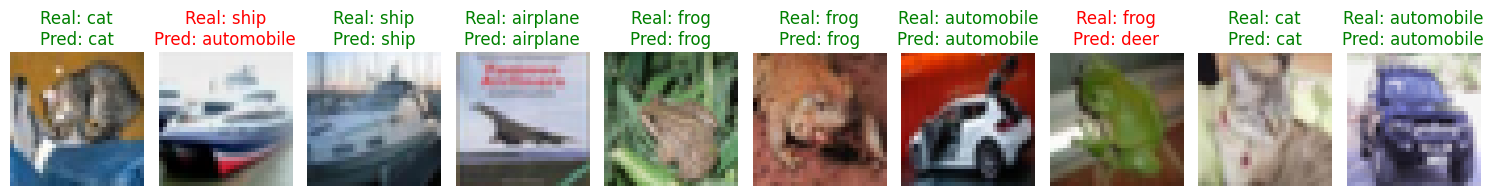

In [129]:
def visualize_predictions(model, test_loader, classes, num_images=10, device="cuda" if torch.cuda.is_available() else "cpu"):
    model.to(device)
    model.eval()

    data_iter = iter(test_loader)
    images, labels = next(data_iter)  # Отримуємо batch
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)  # Отримуємо передбачені класи

    # Візуалізація
    fig, axes = plt.subplots(1, num_images, figsize=(15, 6))

    for i in range(num_images):
        img = images[i].cpu().numpy().transpose((1, 2, 0))  # Перетворення для відображення
        img = img * 0.5 + 0.5  # Денормалізація

        axes[i].imshow(img)
        axes[i].set_title(f"Real: {classes[labels[i].item()]}\nPred: {classes[preds[i].item()]}", color="green" if labels[i] == preds[i] else "red")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()


visualize_predictions(model, test_data, classes, num_images=10, device=device)


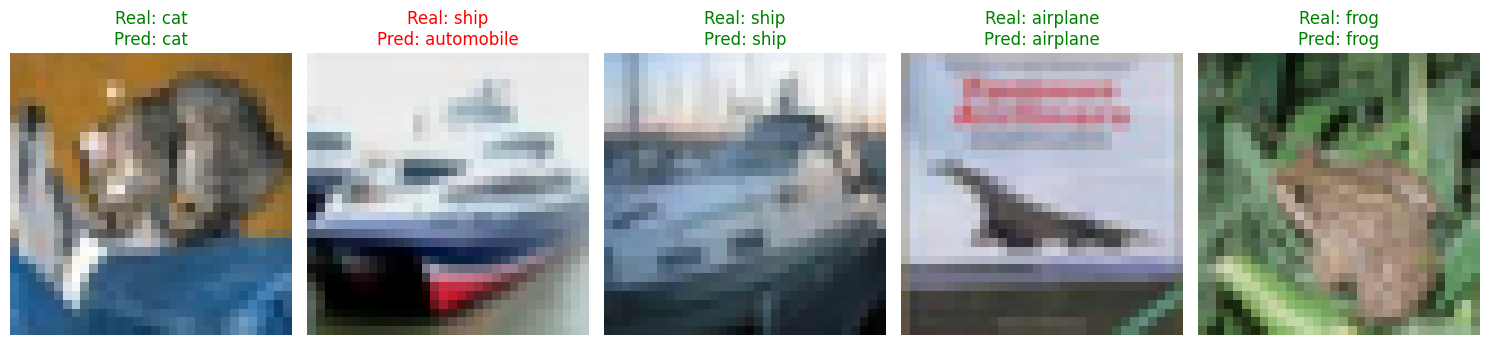

In [130]:
visualize_predictions(model, test_data, classes, num_images=5, device=device)


In [131]:
def plot_training_results(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Графік втрат
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss", marker="o")
    plt.plot(epochs, val_losses, label="Validation Loss", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss per Epoch")
    plt.legend()
    plt.grid()

    # Графік точності
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Train Accuracy", marker="o")
    plt.plot(epochs, val_accuracies, label="Validation Accuracy", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy per Epoch")
    plt.legend()
    plt.grid()

    plt.show()

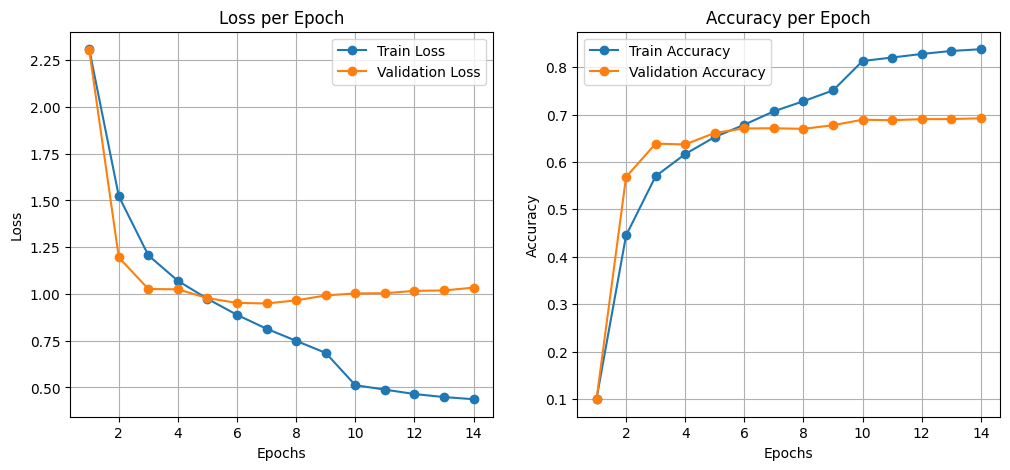

In [132]:
plot_training_results(train_losses, val_losses, train_accuracies, val_accuracies)

## Додаткові завдання (за бажанням):

- Напишіть код, який виведе кількість зображень у кожному класі в директорії train. Для цього ви можете використовувати os.listdir() для підрахунку зображень у відповідних піддиректоріях.
- Створіть графік (наприклад, гістограму), який відображає кількість зображень в кожному класі. Ви можете використовувати бібліотеку matplotlib для візуалізації.
- Виведіть кілька випадкових зображень з кожного класу разом із їхніми мітками.
- Дослідіть, як зміна параметрів підготовки даних (наприклад, різні трансформації) впливає на результати моделі.
- Спробуйте змінити архітектуру моделі (додати додаткові шари) та проаналізуйте, як це впливає на результати.
- Включіть регуляризацію (наприклад, Dropout) для покращення загальної точності.


In [103]:
def count_images_per_class(train_data=train_data.dataset):    
    print("📊 Кількість зображень у кожному класі:")
    labels = [label for _, label in train_data]
    label_counts = Counter(labels)

    for i, cls in enumerate(classes):
        print(f"   {i}: {cls} ({label_counts[i]} зразків)")

    return label_counts

class_counts = count_images_per_class()

📊 Кількість зображень у кожному класі:
   0: airplane (4498 зразків)
   1: automobile (4509 зразків)
   2: bird (4475 зразків)
   3: cat (4515 зразків)
   4: deer (4499 зразків)
   5: dog (4502 зразків)
   6: frog (4521 зразків)
   7: horse (4492 зразків)
   8: ship (4479 зразків)
   9: truck (4510 зразків)


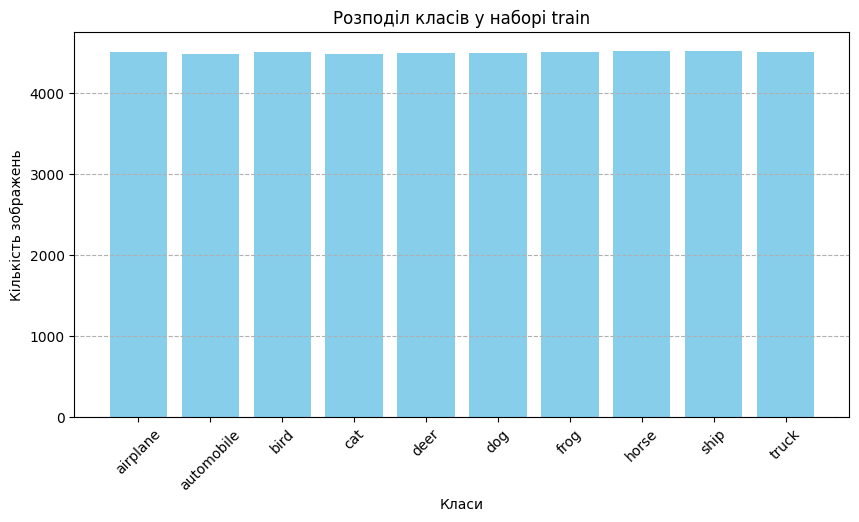

In [106]:
def plot_class_distribution(classes, class_counts):
    plt.figure(figsize=(10, 5))
    plt.bar(classes, class_counts.values(), color="skyblue")
    plt.xlabel("Класи")
    plt.ylabel("Кількість зображень")
    plt.title("Розподіл класів у наборі train")
    plt.xticks(rotation=45)
    plt.grid(axis="y", linestyle="--")
    plt.show()

plot_class_distribution(classes, class_counts)

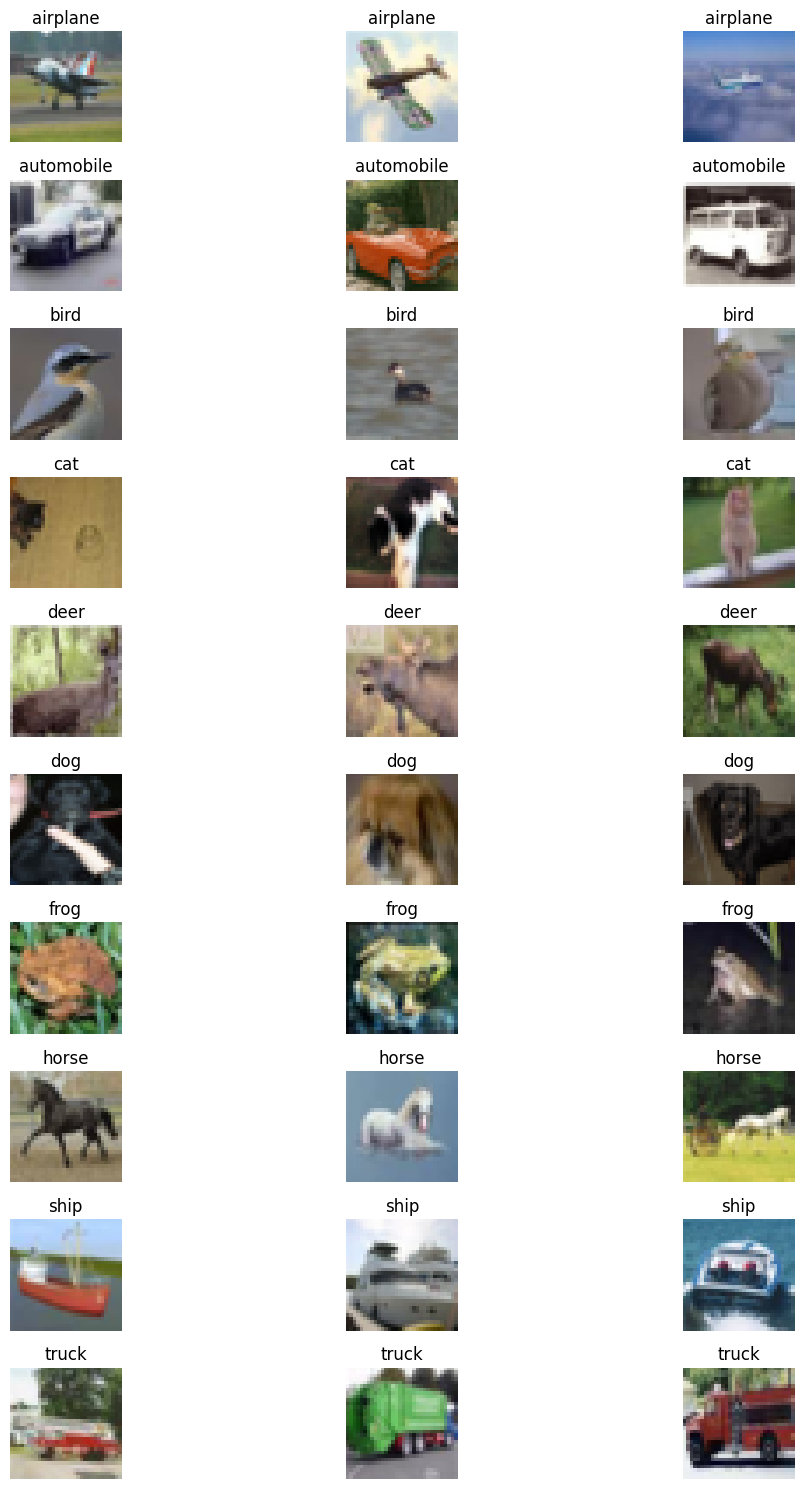

In [112]:
def get_random_images_by_class(train_dataset, classes, num_images_per_class=3):
    class_images = {cls: [] for cls in range(len(classes))}

    # Проходимо через датасет і зберігаємо зображення для кожного класу
    for img, label in train_dataset:
        if len(class_images[label]) < num_images_per_class:
            class_images[label].append(img)
        if all(len(v) == num_images_per_class for v in class_images.values()):
            break  # Вихід, якщо набрали потрібну кількість зображень

    # Візуалізація
    fig, axes = plt.subplots(len(classes), num_images_per_class, figsize=(12, 15))

    for class_idx, images in class_images.items():
        for i, img in enumerate(images):
            img = img.numpy().transpose((1, 2, 0))  # Перетворення для відображення
            img = img * 0.5 + 0.5  # Денормалізація
            
            ax = axes[class_idx, i] if num_images_per_class > 1 else axes[class_idx]
            ax.imshow(img)
            ax.set_title(classes[class_idx])
            ax.axis("off")

    plt.tight_layout()
    plt.show()

get_random_images_by_class(train_data.dataset, classes)
